<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/Neural_networks/NLP/Text_classification/Salary_Prediction_text_classification_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Job Salary Prediction (NLP - text classification)


https://www.kaggle.com/competitions/job-salary-prediction

In [3]:
%%capture
!pip install wandb

In [4]:
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import wandb

from collections import Counter
from IPython.display import display, Image
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.auto import tqdm

In [5]:
%matplotlib inline

In [26]:
WANDB_API = ''
os.environ["WANDB_API_KEY"] = WANDB_API
WANDB_USER = 'dimildizio'
WANDB_PROJECT = 'nlp-job-text-classifier'

In [7]:
%%capture
!wget https://ysda-seminars.s3.eu-central-1.amazonaws.com/Train_rev1.zip

data = pd.read_csv("./Train_rev1.zip", compression='zip', index_col=None)

In [ ]:
data.shape

(244768, 12)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244768 entries, 0 to 244767
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Id                  244768 non-null  int64 
 1   Title               244767 non-null  object
 2   FullDescription     244768 non-null  object
 3   LocationRaw         244768 non-null  object
 4   LocationNormalized  244768 non-null  object
 5   ContractType        65442 non-null   object
 6   ContractTime        180863 non-null  object
 7   Company             212338 non-null  object
 8   Category            244768 non-null  object
 9   SalaryRaw           244768 non-null  object
 10  SalaryNormalized    244768 non-null  int64 
 11  SourceName          244767 non-null  object
dtypes: int64(2), object(10)
memory usage: 22.4+ MB


In [ ]:
data.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


### Drop unnecessary data

In [7]:
df = data.drop(['Id', 'LocationRaw', 'SalaryRaw', 'SourceName', 'SalaryNormalized'], axis=1)
df = df.rename(columns={'LocationNormalized':'Location'})

### Create target column with log of salary to mtigate a huge salary gap which is a result of social inequality. That would help is we want to minimize MSE.

In [8]:
df['SalaryLog'] = np.log1p(data['SalaryNormalized']).astype('float32')

In [ ]:
df.nunique()

Title              135435
FullDescription    242138
Location             2732
ContractType            2
ContractTime            2
Company             20812
Category               29
SalaryLog            8454
dtype: int64

### Fill empty values

(better do that before converting object to category)

<Axes: >

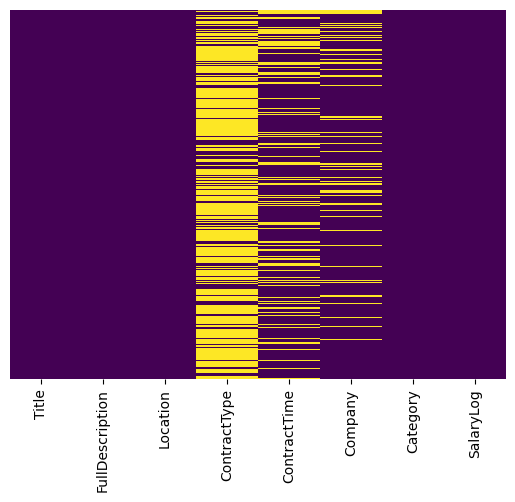

In [ ]:
sns.heatmap(df.isna(), cmap='viridis', yticklabels=False, cbar=False)

In [ ]:
for col in ['ContractType', 'ContractTime', 'Company', 'Title']:
  print(f"{round(df[col].isna().sum() / df[col].shape[0] *100, 4)}% of {col} are NaNs")

73.2637% of ContractType are NaNs
26.1084% of ContractTime are NaNs
13.2493% of Company are NaNs
0.0004% of Title are NaNs


In [ ]:
df[df['Title'].isna()]

,Title,FullDescription,Location,ContractType,ContractTime,Company,Category,SalaryLog
1588,NaN,Quality Improvement Manager North West England...,Liverpool,full_time,NaN,NaN,Healthcare & Nursing Jobs,10.657283


Since we have only one empty value in Title and we know exactly what it is we can fill it in the following way

In [9]:
#Since we have only one missing title
df['Title'] = df['Title'].fillna('quality improvement manager')

Looks like we don't need ContractType but we might be able to fill the values after text classification

In [10]:
df = df.drop(['ContractType'], axis=1)

Same goes for Contract time. Since it's got less than 50% of empty values we leave it in the dataset, but replace NaNs with 'unknown' value

In [11]:
df['ContractTime'] = df['ContractTime'].fillna('UNK')

But we don't touch ['Company'] since it will be addressed later to filter top 1000 companies and fill everything else as 'Other'

<Axes: >

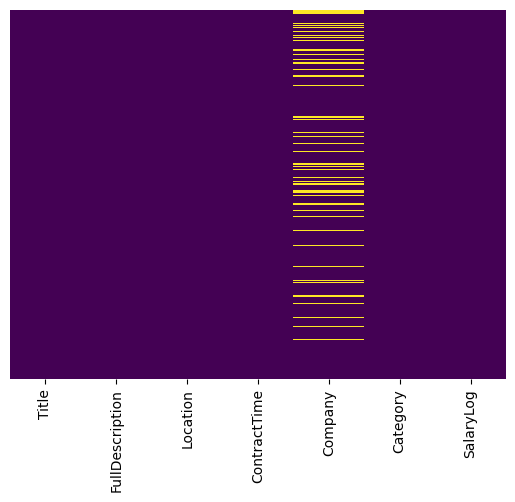

In [ ]:
sns.heatmap(df.isna(), cmap='viridis', yticklabels=False, cbar=False)

### Group columns by purpose

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244768 entries, 0 to 244767
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Title            244768 non-null  object 
 1   FullDescription  244768 non-null  object 
 2   Location         244768 non-null  object 
 3   ContractTime     244768 non-null  object 
 4   Company          212338 non-null  object 
 5   Category         244768 non-null  object 
 6   SalaryLog        244768 non-null  float32
dtypes: float32(1), object(6)
memory usage: 12.1+ MB


In [12]:
TARGET = 'SalaryLog'
TEXT_COLS = ['Title', 'FullDescription']
CATEGORIES = ['FullDescription', 'Location', 'ContractTime', 'Company', 'Category']

## Create tokenizer and tokenize features

In [13]:
WPT = nltk.tokenize.WordPunctTokenizer()

In [14]:
tok_df = df.copy()
for col in TEXT_COLS:
  tok_df[col] = tok_df[col].apply(lambda x: ' '.join(WPT.tokenize(x.lower().replace('_', ''))))

We're also removing all '_' from the strings since their usage just creates more entities.

Could also filter any symbols like ;'#$%^&*!~` using regex or just ord(letter)

### Bathe in tests

In [ ]:
print("Tokenized:")
print(tok_df["FullDescription"][2::100000])
assert tok_df["FullDescription"][2][:50] == 'mathematical modeller / simulation analyst / opera'
assert tok_df["Title"][54321] == 'international digital account manager ( german )'

Tokenized:
2         mathematical modeller / simulation analyst / o...
100002    a successful and high achieving specialist sch...
200002    web designer html , css , javascript , photosh...
Name: FullDescription, dtype: object


## Create an approved list of known word

In [15]:
token_nums = Counter()

for col in TEXT_COLS:
  for row in tok_df[col]:
    token = row.split()
    token_nums.update(token)

### Bathe in tests

In [ ]:
print("Total unique tokens :", len(token_nums))
print('\n'.join(map(str, token_nums.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_nums.most_common()[-3:])))

assert token_nums.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_nums) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202494
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


#### Word frequency histogram

Text(0.5, 0, 'Word counts')

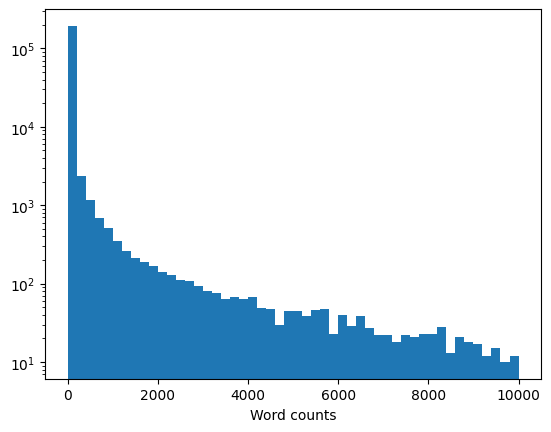

In [ ]:
plt.hist(list(token_nums.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts")

#### We clearly don't need words that occur once or twice in the whole text corpus. Since we don't need those words that spike at the right skew let's filter them.

## Create a list of "approved" tokens as well as "padding" token for short sentences and "unknown" token for words we cut out/haven't encountered in the trainset

In [16]:
UNK, PAD = "UNK", "PAD"
min_count = 10
tokens = [UNK, PAD] + sorted(t for t, c in token_nums.items() if c >= min_count)

### Bathe in tests

In [ ]:
print("Vocabulary size:", len(tokens))
assert type(tokens) == list
assert len(tokens) in range(32000, 35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 34149
Correct!


## Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [17]:
inv_tok_idx = {token:idx for idx, token in enumerate(tokens)}

### Bathe in tests

In [ ]:
assert isinstance(inv_tok_idx, dict)
assert len(inv_tok_idx) == len(tokens)
for tok in tokens:
    assert tokens[inv_tok_idx[tok]] == tok

print("Correct!")

Correct!


### Map text lines into matrices

In [18]:
UNK_IX, PAD_IX = map(inv_tok_idx.get, [UNK, PAD])

In [19]:
def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))

    max_len = min(max(map(len, sequences)), max_len or float('inf'))

    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [inv_tok_idx.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix

    return matrix

In [ ]:
print("Lines:")
print('\n'.join(tok_df["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(tok_df["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[10798 30152  2157     1     1]
 [15012  2835     1     1     1]
 [27636 10192    16 15207 10795]]


### Create category using DictVectorizer and filter top1k most-frequent companies

In [20]:
# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(tok_df['Company']).most_common(1001))

#### Attention: NaN in frequent companies

In [21]:
top5 = {top_companies[x]: top_counts[x] for x in range(5)}
top5

{nan: 32430,
 'UKStaffsearch': 4997,
 'CVbrowser': 2977,
 'London4Jobs': 2345,
 'Hays': 1784}

In [23]:
recognized_companies = set(top_companies)


### Update the Company column with recognized companies or "Other"

In [24]:
def filter_companies(df, frequent_companies = recognized_companies):
  df = df.copy()
  df['Company'] = df['Company'].apply(lambda company: company if company in frequent_companies else 'Other')
  df['Company'] = df['Company'].fillna('Other')
  return df

In [25]:
fltr_df = filter_companies(tok_df)

In [26]:
fltr_df['Company'].unique()

array(['Gregory Martin International', 'Other', 'Code Blue Recruitment',
       ..., 'G2 Legal LTD', 'Hays Education', 'HCL Permanent.'],
      dtype=object)

<Axes: >

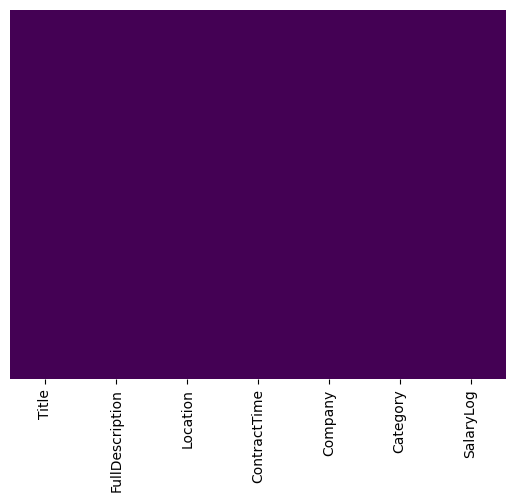

In [ ]:
sns.heatmap(fltr_df.isna(), cmap='viridis', yticklabels=False, cbar=False)

And this is how we replace NaNs with 'Other' and add companies outside of top1000 to 'Other'

### Train DictVectorizer as encoder

In [27]:
dv_df = fltr_df.copy()
categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(dv_df[CATEGORIES].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

### Use TF-IDF instead of DictVectorizer

In [28]:
df_tfidf = fltr_df.copy()
tfidf_vectorizer = TfidfVectorizer(dtype=np.float32, token_pattern=r'\b\w+\b')
tfidf_vectorizer.fit_transform(df_tfidf['Company'])

<244768x969 sparse matrix of type '<class 'numpy.float32'>'
	with 391655 stored elements in Compressed Sparse Row format>

### Convert data types for faster df operations

In [29]:
converted_df = fltr_df.copy()
for column in converted_df.columns:
  if converted_df[column].dtype == 'object':
    converted_df[column] = converted_df[column].astype('category')

Somehow converting string 'object' types to 'category' breaks the code creating issues with assigning new values (since category values should be predefined) and using .apply() so for now we're not gonna use it and are going to convert objeto to category right before feeding the dataset to the model.

#### Check for nans once again (took me half an hour to figure out NaNs weren't fillna'd in ["Company"])

In [ ]:
converted_df.isna().any()

Title              False
FullDescription    False
Location           False
ContractTime       False
Company            False
Category           False
SalaryLog          False
dtype: bool

# Creating a model

## Create a train and a validation datasets

In [30]:
data_train, data_val = train_test_split(converted_df, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", data_train.shape)
print("Validation size = ", data_val.shape)

Train size =  (195814, 7)
Validation size =  (48954, 7)


## Create batches

In [31]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [32]:
def to_tensor(batch, device):
  batch_tensors = {}
  for key, array in batch.items():
    if key in ['FullDescription', 'Title']:
      batch_tensors[key] = torch.tensor(array, device=device, dtype=torch.int64)
    else:
      batch_tensors[key] = torch.tensor(array, device=device)
  return batch_tensors


def drop_words(matrix, keep_prop, replace_with=UNK_IX, pad_with = PAD_IX):
  #dropout cetrain word (actually replace with UNK)
  dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
  dropout_mask &= matrix != pad_with
  return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])


def make_batch(data, maxlen = None, word_dropout=0, device=device):
  batch = {}
  batch['Title'] = as_matrix(data['Title'].values, maxlen)
  batch['FullDescription'] = as_matrix(data['FullDescription'].values, maxlen)
  batch['Categorical'] = categorical_vectorizer.transform(data[CATEGORIES].apply(dict, axis=1))

  if word_dropout:
    batch['FullDescription'] = drop_words(batch['FullDescription'], 1. - word_dropout)
  if TARGET in data.columns:
    batch[TARGET] = data[TARGET].values
  return to_tensor(batch, device)

Getting a looong one-hot for every cat feature value as tensors in Categorical column

In [33]:
new_batch = make_batch(data_train[:3], maxlen=10)

In [37]:
new_batch['Title']

tensor([[27636, 29884, 33665,     1,     1,     1,     1],
        [29230,   197, 19167, 20033, 15546, 23153,  4042],
        [10600, 30403, 17737,    33,  8696, 29148,    65]], device='cuda:0')

### Vectorize the columns using embedding and embeddingbag

In [34]:
linear = nn.Linear(32, 1)

#### embedding

In [35]:
embs = torch.nn.Embedding(len(tokens), 32)
#print(embs(new_batch['Title']).shape)

In [36]:
embs.cuda()

Embedding(34149, 32)

In [37]:
vectors = embs(new_batch['Title']).mean(dim=1)

embedding bag

In [38]:
embb = torch.nn.EmbeddingBag(len(tokens), 32)
embb.cuda()
embb_vectors = embb(new_batch['Title'])

In [ ]:
print(linear(vectors))
print(linear(embb_vectors))

## Model architecture

In [ ]:
url ='https://camo.githubusercontent.com/4acbd3e2fee33a42de561019edd9fd15932993c6201e34f1908d5e18d8cf60ca/68747470733a2f2f6769746875622e636f6d2f79616e646578646174617363686f6f6c2f6e6c705f636f757273652f7261772f6d61737465722f7265736f75726365732f77325f636f6e765f617263682e706e67'
display(Image(url=url))

## Model class

In [13]:
class SalaryModel(nn.Module):
  def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), emb_size=32, conv_out_channels=16, hid_size=64):
    super(SalaryModel, self).__init__()
    #encode title

    self.title_emb = nn.Embedding(n_tokens, emb_size)
    self.title_enc = nn.Sequential(
        nn.Conv1d(emb_size, hid_size, kernel_size=3),
        nn.Dropout(p=0.2),
        nn.ReLU(),
        nn.AdaptiveMaxPool1d(1))

    self.desc_emb = nn.Embedding(n_tokens, emb_size)
    self.desc_enc = nn.Sequential(
        nn.Conv1d(emb_size, hid_size, kernel_size=3),
        nn.Dropout(p=0.2),
        nn.ReLU(),
        nn.AdaptiveMaxPool1d(1))

    self.cat_enc = nn.Sequential(
        nn.Linear(n_cat_features, hid_size*2),
        nn.ReLU(),
        nn.Linear(hid_size*2, hid_size*2),
        nn.ReLU())

    self.predictor = nn.Sequential(
        nn.Linear(hid_size*4, hid_size),
        nn.ReLU(),
        nn.Linear(hid_size, 1))

    self.apply(self._init_weights)


  def _init_weights(self, module):
    if isinstance(module, (nn.Conv1d, nn.Embedding, nn.EmbeddingBag, nn.Linear)):
      nn.init.xavier_uniform_(module.weight)
      if module in (nn.Conv1d, nn.Linear) and not (module.bias is None):
        nn.init.zeros_(module.bias)


  def forward(self, batch):
    title = batch['Title']
    desc = batch['FullDescription']
    cats = batch['Categorical']

    ttl_emb = self.title_emb(title).transpose(1,2)
    ttl_encoded = self.title_enc(ttl_emb).squeeze()

    dsc_emb = self.desc_emb(desc).transpose(1,2)
    dsc_encoded = self.desc_enc(dsc_emb).squeeze()

    linear_cats = self.cat_enc(cats)


    #since we're using _global_ pooling and reduced 1 dimension using .squeeze we don't need to flatten
    concats = torch.cat((ttl_encoded, dsc_encoded, linear_cats), 1)
    outputs = self.predictor(concats)
    return outputs.squeeze(-1)


  def backward(self, loss):
    loss.backward()

#### Run baseline

In [ ]:
device

'cuda'

In [43]:
sm = SalaryModel()
sm.to(device)
sm_pred = sm.forward(new_batch)
sm_pred

tensor([0.1976, 0.1978, 0.2001], device='cuda:0', grad_fn=<SqueezeBackward1>)

In [ ]:
model = SalaryModel()
model.to(device)

batch = make_batch(data_train[:100])

criterion = nn.MSELoss()

dummy_pred = model(batch)
dummy_loss = criterion(dummy_pred, batch['SalaryLog'])
dummy_loss


tensor(108.4991, device='cuda:0', grad_fn=<MseLossBackward0>)

#### Bathe in tests

In [ ]:
assert dummy_pred.shape == torch.Size([100])
assert len(torch.unique(dummy_pred)) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert dummy_loss.ndim == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

# Create a class to train and eval model

In [40]:
BATCH_SIZE=16
EPOCHS=10
LR = 1e-3
OPT = 'SGD'

In [12]:
class Trainmodel:
  def __init__(self, model, optimizer, criterion, batch_size = BATCH_SIZE, epochs = EPOCHS, device=device, WANDB=False):
    self.device = device
    self.model = model.to(device)
    self.criterion = criterion
    self.optimizer = optimizer
    self.batch_size = batch_size
    self.epochs=epochs

    self.wandb=WANDB
    self.init_wandb()

    self.best_mae = float('inf')
    self.best_mse = float('inf')
    self.best_state = None

  def init_wandb(self):
    if self.wandb:
      wandb.login()
      wandb.init(project=WANDB_PROJECT, entity=WANDB_USER, reinit=True)

      wandb.config.epochs = self.epochs
      wandb.config.batch_size = self.batch_size
      wandb.config.learning_rate = LR
      wandb.config.optimizer = OPT
      wandb.config.model_architecture = "NewSalaryModel"


  def iterate_minibatches(self, data, shuffle=True, cycle=False, drop = False, **kwargs):
    while True:
      idx = np.arange(len(data))
      if shuffle:
        idx = np.random.permutation(idx)
      for start in range(0, len(idx), self.batch_size):
        batch = make_batch(data.iloc[idx[start:start+self.batch_size]], word_dropout=drop, device=self.device, **kwargs)
        yield batch
      if not cycle: break


  def print_metrics(self, data, **kwargs):
    sq_err = abs_err = num_samples = 0.0
    self.model.eval()
    with torch.no_grad():
      for batch in self.iterate_minibatches(data, shuffle=False, **kwargs):
        b_pred = self.model(batch)
        sq_err += torch.sum(torch.square(b_pred-batch[TARGET]))
        abs_err += torch.sum(torch.abs(b_pred-batch[TARGET]))
        num_samples += len(b_pred)

    mse = sq_err.detach().cpu().numpy() / num_samples
    mae = abs_err.detach().cpu().numpy() / num_samples

    print(f'Results:\n_____MSE:{round(mse, 5)}\n_____MAE:{round(mae, 5)}\n')
    return mse, mae


  def check_best_score(self, mse, mae):
    if self.best_mae > mae or self.best_mse > mse:
      self.best_mae = mae
      self.best_mse = mse
      self.best_state = self.model.state_dict()


  def train_model(self, data_train, data_val):
    for epoch in range(self.epochs):
      print('EPOCH:', epoch+1)
      running_loss = 0.0
      self.model.train()
      for i, batch in tqdm(enumerate(
          self.iterate_minibatches(data_train, drop=0.05)), total=len(data_train) // self.batch_size
      ):
        y_pred = self.model(batch)
        loss = self.criterion(y_pred, batch[TARGET])
        self.optimizer.zero_grad()
        loss.backward()
        running_loss += loss.item()
        self.optimizer.step()
      mse, mae = self.print_metrics(data_val)
      self.check_best_score(mse, mae)
      if self.wandb:
        wandb.log({'Loss': running_loss, "MSE":mse, 'MAE':mae, 'Best_MSE':self.best_mse, 'Best_MAE':self.best_mae})
    if self.wandb:
      wandb.finish()
    self.model.load_state_dict(self.best_state)

In [ ]:
#Create model
model = SalaryModel().to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=LR)

#Create model trainer
model_trainer = Trainmodel(model, optimizer, criterion, batch_size=BATCH_SIZE, epochs=EPOCHS, WANDB=True)
#Since GPU colab limit has been reached, gotta use CPU and train\validate model on tiny pieces of data and use SGD as it's faster than Adam
model_trainer.train_model(data_train, data_val)
print(f'Best MSE: {model_trainer.best_mse}\nBest MAE: {model_trainer.best_mae}')


wandb: Currently logged in as: dimildizio. Use `wandb login --relogin` to force relogin


EPOCH: 1


  0%|          | 0/12238 [00:00<?, ?it/s]

Results:
_____MSE:0.30944
______MAE:0.48935

EPOCH: 2


  0%|          | 0/12238 [00:00<?, ?it/s]

Results:
_____MSE:0.16945
______MAE:0.34089

EPOCH: 3


  0%|          | 0/12238 [00:00<?, ?it/s]

Results:
_____MSE:0.10279
______MAE:0.24619

EPOCH: 4


  0%|          | 0/12238 [00:00<?, ?it/s]

Results:
_____MSE:0.08956
______MAE:0.22679

EPOCH: 5


  0%|          | 0/12238 [00:00<?, ?it/s]

Results:
_____MSE:0.06833
______MAE:0.19231

EPOCH: 6


  0%|          | 0/12238 [00:00<?, ?it/s]

Results:
_____MSE:0.0667
______MAE:0.18968

EPOCH: 7


  0%|          | 0/12238 [00:00<?, ?it/s]

Results:
_____MSE:0.06672
______MAE:0.19065

EPOCH: 8


  0%|          | 0/12238 [00:00<?, ?it/s]

Results:
_____MSE:0.06333
______MAE:0.18425

EPOCH: 9


  0%|          | 0/12238 [00:00<?, ?it/s]

Results:
_____MSE:0.06358
______MAE:0.18572

EPOCH: 10


  0%|          | 0/12238 [00:00<?, ?it/s]

Results:
_____MSE:0.07783
______MAE:0.2092



Best_MAE,█▅▂▂▁▁▁▁▁▁
Best_MSE,█▄▂▂▁▁▁▁▁▁
Loss,█▃▃▂▂▂▂▁▁▁
MAE,█▅▂▂▁▁▁▁▁▂
MSE,█▄▂▂▁▁▁▁▁▁
Best_MAE,0.18425
Best_MSE,0.06333
Loss,9812.64921
MAE,0.2092
MSE,0.07783


Best MSE: 0.06332707785944458
Best MAE: 0.18425446672513993


# Explaining the result

Straight codepaste

In [ ]:
def explain(model, sample, col_name='Title'):
    """ Computes the effect each word had on model predictions """
    sample = dict(sample)
    sample_col_tokens = [tokens[inv_tok_idx.get(tok, 0)] for tok in sample[col_name].split()]
    data_drop_one_token = pd.DataFrame([sample] * (len(sample_col_tokens) + 1))

    for drop_i in range(len(sample_col_tokens)):
        data_drop_one_token.loc[drop_i, col_name] = ' '.join(UNK if i == drop_i else tok
                                                   for i, tok in enumerate(sample_col_tokens))

    *predictions_drop_one_token, baseline_pred = model(make_batch(data_drop_one_token, device=device)).detach().cpu()
    diffs = baseline_pred - torch.Tensor(predictions_drop_one_token)
    return list(zip(sample_col_tokens, diffs))

In [ ]:
from IPython.display import HTML, display_html


def draw_html(tokens_and_weights, cmap=plt.get_cmap("bwr"), display=True,
              token_template="""<span style="background-color: {color_hex}">{token}</span>""",
              font_style="font-size:14px;"
             ):

    def get_color_hex(weight):
        rgba = cmap(1. / (1 + np.exp(float(weight))), bytes=True)
        return '#%02X%02X%02X' % rgba[:3]

    tokens_html = [
        token_template.format(token=token, color_hex=get_color_hex(weight))
        for token, weight in tokens_and_weights
    ]


    raw_html = """<p style="{}">{}</p>""".format(font_style, ' '.join(tokens_html))
    if display:
        display_html(HTML(raw_html))

    return raw_html


In [ ]:
i = 36605
tokens_and_weights = explain(model, converted_df.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, converted_df.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights])

sales specialist iv access and infusion

sales representative medical sales iv access and infusion an opportunity to work for the industry leading manufacturer of iv access and infusion solutions . formally recognised as the number **** company in this market space , our client are an ethical and dynamic organisation absolutely committed to the advancement of innovative technologies . job title : sales specialist iv access and infusion selling : medication delivery solutions selling to : iv teams , infection control , lead intensive care nurse specialists , ward managers territory : east midlands location : east midlands package : basic : **** k **** k , uncapped bonus in addition , full corporate benefits company information hugely ethical and professional global organisation extremely well established in the uk the market leader across all of their core business areas focus on providing cutting edge solutions along with outstanding service and support a business that retain talented personnel by offering a strong platform for career development sales specialist iv access and infusion you must have / be the following at least 2 years medical device sales experience . candidates who have sold disposables / consumables or similar into hospitals would be of particular interest . candidates must have sold into hospitals demonstrable performance and achievements so far personable , adaptable and willing to learn keen and eager to be a success candidates must have a degree or at least be able to show a strong ability to learn role information managing the east midlands region selling across the company ' s range of iv and infusion solutions portfolio selling into lead intensive care nurse specialists , ward managers , iv teams , infection control teams , procurement sales specialist iv access and infusion candidates must be eligible to work and live in the uk . please contact allan waller on **** **** **** or please hit the apply button . this job was originally posted as www . salestarget . co . uk / jobseeking / UNK ****

'<p style="font-size:14px;"><span style="background-color: #FFDADA">sales</span> <span style="background-color: #FFDADA">representative</span> <span style="background-color: #FFDADA">medical</span> <span style="background-color: #FFDADA">sales</span> <span style="background-color: #FFDADA">iv</span> <span style="background-color: #FFDADA">access</span> <span style="background-color: #FFDADA">and</span> <span style="background-color: #FFDADA">infusion</span> <span style="background-color: #FFDADA">an</span> <span style="background-color: #FFDADA">opportunity</span> <span style="background-color: #FFDADA">to</span> <span style="background-color: #FFDADA">work</span> <span style="background-color: #FFDADA">for</span> <span style="background-color: #FFDADA">the</span> <span style="background-color: #FFDADA">industry</span> <span style="background-color: #FFDADA">leading</span> <span style="background-color: #FFDADA">manufacturer</span> <span style="background-color: #FFDADA">of</span> <spa

In [ ]:
i = 1207
tokens_and_weights = explain(model, converted_df.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, converted_df.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

rgn deputy manager northumberland

rgn qualified deputy manager northumberland **** per hour in touch recruitment are working on behalf of wellregarded nursing home group to recruit an experienced rgn deputy home manager for their medium sized nursing service in the stocksfield area of northumberland . the role will involve working alongside an experienced home manager to run and manage the service successfully . as deputy manager you will take an active clinical lead , overseeing care being delivered within the service whilst maintaining high standards at all times . working alongside the home manager you will supervise a multidisciplinary team and deal with all aspects of staff recruitment , disciplinary and appraisals and also play a key part in training and developing staff . the successful candidate will hold a 1st level nurse rgn qualification and active nmc pin . the role requires a strong nurse who has experience working within a nursing home environment within a supervisory role . to apply please send your cv across to danielle at danielleintouchrecruitment . co . uk or alternatively call **** **** **** for an application form keywords sister , deputy home manager , deputy nursing home manager , , head of care , nurse , nursing home , rgn , senior nurse , sister , elderly care , deputy home manager , clinical lead , newcastle , northumberland , stocksfield , tyne and wear , north east

Blue colors show the values that negatively affected the prediction

Red colors show values that positively affected the prediction

The intensity of color represents how huge was the effect

In [ ]:
JOBS_N = 2

i = np.random.randint(len(converted_df))
print("Index:", i)
print("Salary (gbp):", np.expm1(model(make_batch(converted_df.iloc[i: i+JOBS_N], device=device)).detach().cpu()))

tokens_and_weights = explain(model, converted_df.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, converted_df.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

Index: 103247
Salary (gbp): tensor([22235.4922, 25168.2676])


manufacturing technician metal finishing

manufacturing technician with a background in metal finishing to join a leading manufacturer of aircraft parts . the business has recently won a major new aircraft programme to add to their already impressive portfolio . manufacturing technician hampshire **** k **** k bens final salary pension manufacturing technician with a background in metal finishing to join a leading manufacturer of aircraft parts . the business has recently won a major new aircraft programme to add to their already impressive portfolio . you will be working to tight tolerances during the component manufacture , set and operate manual and / or numerical plating controls and produce complete programs and editing of supplier programs . you & x2019 ll liaise with the cell engineer and treatments development specialist on planned methods of work and layouts . you & x2019 ll also take responsibility for the state and correctness of any tooling , fixtures and gauging . you will be from an aerospace / aircraft manufacturing background or automotive precision engineering . you will have metal finishing experience together with an nvq level 2 or equivalent . you will be proficient in correcting tooling , fixtures and gauging . this is a great opportunity to become part of a major employer which offers career development and attractive remuneration packages . to apply , call samantha on **** **** **** or s . tildsleyjamrecruitment . view our latest jobs today at www . jamrecruitment . co . uk and follow us on facebook , twitter & linkedin jam recruitment is acting as an employment agency with regards to this position .

Since the vectorizer doesn't take the order into account and a plain embedding is a simple technique we don't get the perfect results. Also for some values the colorcode is completely red or blue, which means sometimes the whole texts of description has been taken into account as a single vector and vector values have been average (no shit, Sherlock!).

### Issues

The following issues should be addressed after that:


1.   Dimensionality - IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1). Occurs only if one values is passed to predict.
2.   Padding size - RuntimeError: Calculated padded input size per channel: (2). Kernel size: (3). Kernel size can't be greater than actual input size. (possible solution - to remove padding in model and deal with cosequences)
3.    Explained result - Whole description column is colored red or blue depending how it is viewed by the model. Applying better vectorizer might help.


# Try RNN

#### Set up most important variable

since gpu in colab disconnects all the time - rerun everything in two clicks

In [10]:
def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))

    max_len = min(max(map(len, sequences)), max_len or float('inf'))

    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [inv_tok_idx.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    return matrix


df = data.drop(['Id', 'LocationRaw', 'SalaryRaw', 'SourceName', 'SalaryNormalized'], axis=1)
df = df.rename(columns={'LocationNormalized':'Location'})
df['SalaryLog'] = np.log1p(data['SalaryNormalized']).astype('float32')
df['Title'] = df['Title'].fillna('quality improvement manager')
df = df.drop(['ContractType'], axis=1)
df['ContractTime'] = df['ContractTime'].fillna('UNK')
TARGET = 'SalaryLog'
TEXT_COLS = ['Title', 'FullDescription']
CATEGORIES = ['FullDescription', 'Location', 'ContractTime', 'Company', 'Category']
WPT = nltk.tokenize.WordPunctTokenizer()
tok_df = df.copy()
for col in TEXT_COLS:
  tok_df[col] = tok_df[col].apply(lambda x: ' '.join(WPT.tokenize(x.lower().replace('_', ''))))
token_nums = Counter()
for col in TEXT_COLS:
  for row in tok_df[col]:
    token = row.split()
    token_nums.update(token)
UNK, PAD = "UNK", "PAD"
min_count = 10
tokens = [UNK, PAD] + sorted(t for t, c in token_nums.items() if c >= min_count)
inv_tok_idx = {token:idx for idx, token in enumerate(tokens)}
UNK_IX, PAD_IX = map(inv_tok_idx.get, [UNK, PAD])


def drop_words(matrix, keep_prop, replace_with=UNK_IX, pad_with = PAD_IX):
  #dropout cetrain word (actually replace with UNK)
  dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
  dropout_mask &= matrix != pad_with
  return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])


top_companies, top_counts = zip(*Counter(tok_df['Company']).most_common(1001))
recognized_companies = set(top_companies)


def filter_companies(df, frequent_companies = recognized_companies):
  df = df.copy()
  df['Company'] = df['Company'].apply(lambda company: company if company in frequent_companies else 'Other')
  df['Company'] = df['Company'].fillna('Other')
  return df

def to_tensor(batch, device):
  batch_tensors = {}
  for key, array in batch.items():
    if key in ['FullDescription', 'Title']:
      batch_tensors[key] = torch.tensor(array, device=device, dtype=torch.int64)
    else:
      batch_tensors[key] = torch.tensor(array, device=device)
  return batch_tensors

fltr_df = filter_companies(tok_df)
dv_df = fltr_df.copy()
categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(dv_df[CATEGORIES].apply(dict, axis=1))
df_tfidf = fltr_df.copy()
tfidf_vectorizer = TfidfVectorizer(dtype=np.float32, token_pattern=r'\b\w+\b')
tfidf_vectorizer.fit_transform(df_tfidf['Company'])
converted_df = fltr_df.copy()
for column in converted_df.columns:
  if converted_df[column].dtype == 'object':
    converted_df[column] = converted_df[column].astype('category')
data_train, data_val = train_test_split(converted_df, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def make_batch(data, maxlen = None, word_dropout=0, device=device):
  batch = {}
  batch['Title'] = as_matrix(data['Title'].values, maxlen)
  batch['FullDescription'] = as_matrix(data['FullDescription'].values, maxlen)
  batch['Categorical'] = categorical_vectorizer.transform(data[CATEGORIES].apply(dict, axis=1))

  if word_dropout:
    batch['FullDescription'] = drop_words(batch['FullDescription'], 1. - word_dropout)
  if TARGET in data.columns:
    batch[TARGET] = data[TARGET].values
  return to_tensor(batch, device)

new_batch = make_batch(data_train[:3], maxlen=10)
embs = torch.nn.Embedding(len(tokens), 32)
embs.cuda()
vectors = embs(new_batch['Title']).mean(dim=1)
embb = torch.nn.EmbeddingBag(len(tokens), 32)
embb.cuda()
embb_vectors = embb(new_batch['Title'])
BATCH_SIZE=16
EPOCHS=10
LR = 1e-3
OPT = 'SGD'

## RNN model LSTM

Inheritance would mess things up. After all theonly things that doesn't change is _init_weights and backward. Could later write and abstract class for them and inheret from it.

In [18]:
class RNNSalaryModel(nn.Module):
  def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), emb_size=32, hid_size=64):
    super(RNNSalaryModel, self).__init__()
    self.title_emb = nn.Embedding(n_tokens, emb_size)
    self.title_enc = nn.LSTM(emb_size, hid_size, batch_first=True)

    self.desc_emb = nn.Embedding(n_tokens, emb_size)
    self.desc_enc = nn.LSTM(emb_size, hid_size, batch_first=True)

    self.cat_enc = nn.Sequential(
        nn.Linear(n_cat_features, hid_size*2),
        nn.ReLU(),
        nn.Linear(hid_size*2, hid_size*2),
        nn.ReLU())

    self.predictor = nn.Sequential(
        nn.Linear(hid_size*4, hid_size),
        nn.ReLU(),
        nn.Linear(hid_size, 1))

    self.apply(self._init_weights)


  def _init_weights(self, module):
    if isinstance(module, (nn.Conv1d, nn.Embedding, nn.EmbeddingBag, nn.Linear)):
      nn.init.xavier_uniform_(module.weight)
      if module in (nn.Conv1d, nn.Linear) and not (module.bias is None):
        nn.init.zeros_(module.bias)


  def forward(self, batch):
    title = batch['Title']
    desc = batch['FullDescription']
    cats = batch['Categorical']

    ttl_emb = self.title_emb(title)
    ttl_encoded, _ = self.title_enc(ttl_emb)

    dsc_emb = self.desc_emb(desc)
    dsc_encoded, _ = self.desc_enc(dsc_emb)

    linear_cats = self.cat_enc(cats)

    concats = torch.cat((ttl_encoded[:, -1, :], dsc_encoded[:, -1, :], linear_cats), 1)
    outputs = self.predictor(concats)
    return outputs.squeeze(-1)


  def backward(self, loss):
    loss.backward()

### Create model

In [19]:
model = RNNSalaryModel().to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=LR)

### Train model

In [21]:
model_trainer = Trainmodel(model, optimizer, criterion, batch_size=BATCH_SIZE, epochs=EPOCHS, WANDB=True)
model_trainer.train_model(data_train, data_val)
print(f'Best MSE: {model_trainer.best_mse}\nBest MAE: {model_trainer.best_mae}')

wandb: Currently logged in as: dimildizio. Use `wandb login --relogin` to force relogin


EPOCH: 1


  0%|          | 0/12238 [00:00<?, ?it/s]

Results:
_____MSE:0.15397
______MAE:0.30583

EPOCH: 2


  0%|          | 0/12238 [00:00<?, ?it/s]

Results:
_____MSE:0.14981
______MAE:0.30067

EPOCH: 3


  0%|          | 0/12238 [00:00<?, ?it/s]

Results:
_____MSE:0.14635
______MAE:0.2966

EPOCH: 4


  0%|          | 0/12238 [00:00<?, ?it/s]

Results:
_____MSE:0.14449
______MAE:0.29503

EPOCH: 5


  0%|          | 0/12238 [00:00<?, ?it/s]

Results:
_____MSE:0.13964
______MAE:0.2899

EPOCH: 6


  0%|          | 0/12238 [00:00<?, ?it/s]

Results:
_____MSE:0.11182
______MAE:0.25254

EPOCH: 7


  0%|          | 0/12238 [00:00<?, ?it/s]

Results:
_____MSE:0.10158
______MAE:0.23867

EPOCH: 8


  0%|          | 0/12238 [00:00<?, ?it/s]

Results:
_____MSE:0.09535
______MAE:0.23096

EPOCH: 9


  0%|          | 0/12238 [00:00<?, ?it/s]

Results:
_____MSE:0.09864
______MAE:0.23642

EPOCH: 10


  0%|          | 0/12238 [00:00<?, ?it/s]

Results:
_____MSE:0.09294
______MAE:0.22793



Best_MAE,██▇▇▇▃▂▁▁▁
Best_MSE,██▇▇▆▃▂▁▁▁
Loss,█▅▅▄▄▃▂▂▁▁
MAE,██▇▇▇▃▂▁▂▁
MSE,██▇▇▆▃▂▁▂▁
Best_MAE,0.22793
Best_MSE,0.09294
Loss,13155.60871
MAE,0.22793
MSE,0.09294


Best MSE: 0.09294044696296523
Best MAE: 0.22792989496517138


In [24]:
model_trainer.device

'cuda'

Initialized weights and the first epoch with RNN show better results, decreasing with each epochs, but training takes forever and more epochs than CNN

### Biderectional LSTM

In [23]:
class BiRNNSalaryModel(nn.Module):
  def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), emb_size=32, hid_size=64):
    super(BiRNNSalaryModel, self).__init__()
    self.title_emb = nn.Embedding(n_tokens, emb_size)
    self.title_enc_forward = nn.LSTM(emb_size, hid_size, batch_first=True)
    self.title_enc_backward = nn.LSTM(emb_size, hid_size, batch_first=True)


    self.desc_emb = nn.Embedding(n_tokens, emb_size)
    self.desc_enc_forward = nn.LSTM(emb_size, hid_size, batch_first=True)
    self.desc_enc_backward = nn.LSTM(emb_size, hid_size, batch_first=True)

    self.cat_enc = nn.Sequential(
        nn.Linear(n_cat_features, hid_size*2),
        nn.ReLU(),
        nn.Linear(hid_size*2, hid_size*2),
        nn.ReLU())

    self.predictor = nn.Sequential(
        nn.Linear(hid_size*4, hid_size),
        nn.ReLU(),
        nn.Linear(hid_size, 1))

    self.apply(self._init_weights)


  def _init_weights(self, module):
    if isinstance(module, (nn.Conv1d, nn.Embedding, nn.EmbeddingBag, nn.Linear)):
      nn.init.xavier_uniform_(module.weight)
      if module in (nn.Conv1d, nn.Linear) and not (module.bias is None):
        nn.init.zeros_(module.bias)


  def forward(self, batch):
    title = batch['Title']
    desc = batch['FullDescription']
    cats = batch['Categorical']

    ttl_emb = self.title_emb(title)
    ttl_encoded_forward, _ = self.title_enc_forward(ttl_emb)
    ttl_encoded_backward, _ = self.title_enc_backward(torch.flip(ttl_emb, [1]))

    dsc_emb = self.desc_emb(desc)
    dsc_encoded_forward, _ = self.desc_enc_forward(dsc_emb)
    dsc_encoded_backward, _ = self.dsc_enc_backward(torch.flip(dsc_emb, [1]))

    linear_cats = self.cat_enc(cats)

    concats_forward = torch.cat((ttl_encoded_forward[:, -1, :], dsc_encoded_forward[:, -1, :], linear_cats), 1)
    concats_backward = torch.cat((ttl_encoded_backward[:, -1, :], dsc_encoded_backward[:, -1, :], linear_cats), 1)

    concats = torch.cat((concats_forward, concats_backward), dim=-1)
    outputs = self.predictor(concats)
    return outputs.squeeze(-1)


  def backward(self, loss):
    loss.backward()

In [25]:
LR = 1e-2
model = BiRNNSalaryModel().to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=LR)

In [ ]:
model_trainer = Trainmodel(model, optimizer, criterion, batch_size=BATCH_SIZE, epochs=5, WANDB=True)
model_trainer.train_model(data_train, data_val)
print(f'Best MSE: {model_trainer.best_mse}\nBest MAE: {model_trainer.best_mae}')